## Citation
This notebook is inspired by, and tries to expand on [Leonardo Fuchs's](https://www.kaggle.com/leofuchs/predicting-who-will-win-cloud9-matches-in-lol) analysis on Cloud9 League of Legends matches. This data set has been generated by [Chuck Efron](https://www.kaggle.com/chuckephron/leagueoflegends). 

## Introduction
League of Legends (LoL) is a multiplayer online battle arena (MOBA) game developed by Riot Games. League of Legends gameplay most commonly takes the form of 5 vs. 5 arena matches. During these matches, the player controls a single "champion" and is assigned to a 5 player team. Their team pitted against an enemy 5 man team of human players. The two teams fight on a recurring, nearly symmetrical, square map with one team starting on the top right as the Red team, and the other starting on the bottom left as the Blue team. The goal is to take the enemy team's nexus, a structure protected by defensive turrets called towers, physical walls, and autonomous minions. The map contains many optional objectives which provide rewards to the team or player, which could improve their chances of winning the game. Killable monsters such as minions, baron, and dragon can be killed for gold or buffs. Enemy towers can be taken to allow friendly minions to creep closer to the enemy nexus and destroying enemy inhibitors makes friendly minions temporarily stronger. 

## Goals
Teams must efficiently choose between the various objectives to try to increase their chance of winning. Deciding which objectives are most meaningful or impactful can be a challenge, especially taking time to secure a certain objective can result in losing a different objective to the enemy team. 

We present two goals for our analysis: 
1. Determine which objectives are most impactful to the game outcome, specifically, which objectives significantly increase the chances of winning the game, and which objectives, when taken by the enemy team, significantly decrease the chances of winning the game.

2. After determining the most impactful objectives, we will attempt to train a classification model to predict the winner of a game based on the objectives taken by each team at the 30 minute mark. 

![Map](https://images.contentstack.io/v3/assets/blt731acb42bb3d1659/blteee710504baccf73/618e1709d11a66021302719a/objective_bounty_map.png?disposition=inline)

In [1]:
# import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import statsmodels.api as sm
import math
%matplotlib inline

from pandas import DataFrame
from subprocess import check_output
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Dataset
League of Legends features a worldwide competitive scene. To support this, Riot Games hosts the League Championship Series (LCS), a worldwide tournament series split into regions such as North America, Europe, and South Korea. The dataset includes LCS matches between 2015-2017, from NALCS, EULCS, LCK, LMS and CBLoL, and the World Championship and Mid-Season Invitational tournaments. The dataset was generated by [Chuck Efron](https://www.kaggle.com/chuckephron) and is available on Kaggle [here](https://www.kaggle.com/chuckephron/leagueoflegends).      

Like Fuchs, we will analyze a subset of the available columns. The columns and their descriptions are provided. 

- `blueTeamTag` Blue Team's tag name (ex. Team SoloMid is TSM)
- `bResult` Result of the match for Blue Team 1 is a win, 0 is a loss 
- `goldblue`	Blue Team's total gold value by minute
- `bKills`	List of Blue Team's kills - [Time in minutes, Victim, Killer, Assist1, Assist2, Assist3, Assist4, x_pos, y_pos]
- `bTowers`	List of minutes that Blue Team destroyed a tower and Tower Location
- `bInhibs`	List of minutes that Blue Team destroyed an inhibitor and Location
- `bDragons`	List of minutes that Blue Team killed a dragon
- `bBarons`	List of minutes that Blue Team killed a baron
- `bHeralds`	List of minutes that Blue Team killed a rift herald 
- `redTeamTag` Red Team's tag name (ex. Cloud9 is C9)
- `bResult` Result of the match for Red Team 1 is a win, 0 is a loss 
- `goldblue`	Red Team's total gold value by minute
- `bKills`	List of Red Team's kills - [Time in minutes, Victim, Killer, Assist1, Assist2, Assist3, Assist4, x_pos, y_pos]
- `bTowers`	List of minutes that Red Team destroyed a tower and Tower location
- `bInhibs`	List of minutes that Red Team destroyed an inhibitor and location
- `bDragons`	List of minutes that Red Team killed a dragon
- `bBarons`	List of minutes that Red Team killed a baron
- `bHeralds`	List of minutes that Red Team killed a rift herald 

In [2]:
# Data info
df_columns = pd.read_csv('../input/leagueoflegends/_columns.csv',sep=',')
df_original = pd.read_csv('../input/leagueoflegends/LeagueofLegends.csv',sep=',')

df_original[['bResult','goldblue','bKills','bTowers', 'bInhibs', 'bDragons', 'bBarons', 'bHeralds']].head(15)

,bResult,goldblue,bKills,bTowers,bInhibs,bDragons,bBarons,bHeralds
0,1,"[2415, 2415, 2711, 3887, 5068, 6171, 7412, 866...","[[10.82, 'C9 Hai', 'TSM Bjergsen', [], 9229, 8...","[[27.542, 'MID_LANE', 'BASE_TURRET'], [39.269,...","[[36.686, 'MID_LANE'], [29.274, 'MID_LANE']]","[[37.267, None]]",[],[]
1,0,"[2415, 2415, 2705, 4108, 5511, 6797, 7637, 895...","[[11.104, 'DIG Shiphtur', 'CST Jesiz', ['CST I...","[[23.239, 'BOT_LANE', 'OUTER_TURRET'], [33.018...",[],"[[32.545, None], [26.177, None], [19.119, None]]",[[29.255]],[]
2,1,"[2415, 2415, 2726, 3794, 4933, 6236, 8109, 965...","[[5.255, 'GV Keane', 'WFX Pobelter', ['WFX Sho...","[[15.045, 'BOT_LANE', 'OUTER_TURRET'], [39.566...","[[37.511, 'TOP_LANE'], [37.38, 'BOT_LANE'], [3...","[[24.577, None], [37.867, None], [30.87, None]...",[[35.144]],[]
3,0,"[2415, 2415, 2705, 3847, 5398, 6473, 7720, 930...","[[8.274, 'TL Quas', 'TIP Rhux', ['TIP Apollo']...","[[19.941, 'BOT_LANE', 'OUTER_TURRET'], [38.77,...",[],[],[[37.513]],[]
4,1,"[2415, 2415, 2710, 3950, 5404, 6666, 7887, 913...","[[11.438, 'T8 Dodo8', 'CLG Doublelift', ['CLG ...","[[22.594, 'MID_LANE', 'OUTER_TURRET'], [34.213...","[[34.069, 'BOT_LANE']]","[[14.589, None], [30.307, None]]",[[32.556]],[]
5,0,"[2415, 2415, 2725, 3863, 5244, 6585, 7683, 903...","[[11.143, 'TIP Adrian', 'DIG KiWiKiD', ['DIG C...",[],[],[],[],[]
6,1,"[2415, 2433, 2734, 4031, 5258, 6651, 7855, 909...","[[7.242, 'WFX Flaresz', 'CST Impaler', ['CST C...","[[24.494, 'TOP_LANE', 'INNER_TURRET'], [19.684...","[[35.782, 'BOT_LANE'], [33.34, 'MID_LANE']]","[[36.126, None], [22.526, None], [16.372, None]]",[[28.745]],[]
7,1,"[2415, 2415, 2731, 3921, 5089, 6674, 7693, 891...","[[4.413, 'CLG Xmithie', 'TL Xpecial', [], 2706...","[[14.046, 'MID_LANE', 'OUTER_TURRET'], [35.704...","[[41.77, 'BOT_LANE'], [39.591, 'TOP_LANE'], [3...","[[11.316, None], [18.091, None], [24.829, None]]","[[31.577], [39.029]]",[]
8,0,"[2415, 2415, 2721, 3938, 5363, 6694, 8144, 943...","[[7.593, 'GV Saintvicious', 'C9 Balls', ['C9 H...","[[24.108, 'TOP_LANE', 'INNER_TURRET'], [19.079...",[],[],[[21.657]],[]
9,1,"[2415, 2415, 2711, 3949, 5648, 6631, 8081, 947...","[[3.652, 'TSM Dyrus', 'T8 Porpoise8', ['T8 Cal...","[[19.95, 'BOT_LANE', 'OUTER_TURRET'], [22.194,...","[[26.337, 'MID_LANE'], [30.018, 'TOP_LANE'], [...","[[19.537, None]]",[[27.532]],[]


In [3]:
# dataframe information
df_original.info()
df = df_original.copy(deep=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7620 entries, 0 to 7619
Data columns (total 57 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   League            7620 non-null   object
 1   Year              7620 non-null   int64 
 2   Season            7620 non-null   object
 3   Type              7620 non-null   object
 4   blueTeamTag       7582 non-null   object
 5   bResult           7620 non-null   int64 
 6   rResult           7620 non-null   int64 
 7   redTeamTag        7583 non-null   object
 8   gamelength        7620 non-null   int64 
 9   golddiff          7620 non-null   object
 10  goldblue          7620 non-null   object
 11  bKills            7620 non-null   object
 12  bTowers           7620 non-null   object
 13  bInhibs           7620 non-null   object
 14  bDragons          7620 non-null   object
 15  bBarons           7620 non-null   object
 16  bHeralds          7620 non-null   object
 17  goldred       

## Preparing the Dataset

1. Turn psudolists into real lists.
2. Turn objects into more applicable data types. 

In [4]:
# Transform all the columns containing pseudo lists to real lists

df['goldblue'] = df['goldblue'].apply(literal_eval)
df['bKills'] = df['bKills'].apply(literal_eval)
df['bTowers'] = df['bTowers'].apply(literal_eval)
df['bInhibs'] = df['bInhibs'].apply(literal_eval)
df['bDragons'] = df['bDragons'].apply(literal_eval)
df['bBarons'] = df['bBarons'].apply(literal_eval)
df['bHeralds'] = df['bHeralds'].apply(literal_eval)

df['goldred'] = df['goldred'].apply(literal_eval)
df['rKills'] = df['rKills'].apply(literal_eval)
df['rTowers'] = df['rTowers'].apply(literal_eval)
df['rInhibs'] = df['rInhibs'].apply(literal_eval)
df['rDragons'] = df['rDragons'].apply(literal_eval)
df['rBarons'] = df['rBarons'].apply(literal_eval)
df['rHeralds'] = df['rHeralds'].apply(literal_eval)

In [5]:
df.head(5)
print(df['bKills'][1])
print(df['bTowers'][1])

[[11.104, 'DIG Shiphtur', 'CST Jesiz', ['CST Impaler'], 9294, 8716], [12.332, 'DIG Crumbzz', 'CST Cris', ['CST Sheep'], 9601, 5282], [12.392, 'DIG CoreJJ', 'CST Cris', ['CST Impaler', 'CST Mash'], 9967, 6811], [12.665, 'DIG Gamsu', 'CST Cris', ['CST Impaler', 'CST Mash', 'CST Sheep'], 10870, 5390], [14.837, 'DIG Crumbzz', 'CST Mash', ['CST Sheep'], 8556, 2686], [25.008, 'DIG KiWiKiD', 'CST Jesiz', ['CST Cris', 'CST Impaler', 'CST Mash', 'CST Sheep'], 9648, 6310], [25.134, 'DIG CoreJJ', 'CST Mash', ['CST Cris', 'CST Impaler', 'CST Jesiz', 'CST Sheep'], 9646, 6344], [28.412, 'DIG Crumbzz', 'CST Jesiz', ['CST Impaler', 'CST Mash', 'CST Sheep'], 8786, 8643], [30.128, 'DIG CoreJJ', 'CST Impaler', ['CST Cris', 'CST Mash'], 4790, 4742], [32.367, 'DIG KiWiKiD', 'CST Jesiz', ['CST Impaler', 'CST Sheep'], 10142, 7246]]
[[23.239, 'BOT_LANE', 'OUTER_TURRET'], [33.018, 'BOT_LANE', 'INNER_TURRET'], [28.989, 'BOT_LANE', 'FOUNTAIN_TURRET'], [25.564, 'MID_LANE', 'OUTER_TURRET'], [20.058, 'BOT_LANE', 'F

In [6]:
# Capturing only the information that interests us from the data lists

data = pd.DataFrame()

# Set cutoff
df = df[df.gamelength > 31]
cutoff_mins = 30

# only analyze the objectives that occured before 30 minutes
# can make a new dataframe (a series essentially), remove all the objectives captured after cutoff time

def objectives_before(column: pd.Series, length: float):
    '''Retrieves objectives obtained before a defined time, from the list of lists in dataset
    
    Parameters
    ----------
    column : pd.Series
        series containing the list of lists of lists of a particular objective
    length : float
        grab objectives from before this time
        
    Returns
    -------
    wanted_objs : list
        list of lists (games), with the 2nd level only containing the objectives before the desired time  
    
    '''
    
    column = column.to_list()
    wanted_objs = []
    for i, game in enumerate(column):
        #print("game: ", game)
        wanted_objs.append([])
        for obj in game: 
            #print("kill in game: ", kill)
            if obj[0] < length:
                wanted_objs[i].append(obj)
    #print(wanted_kills)
    
    #wanted_kills = [kill for kill in series_to_list if kill[0][0] < length]
    return wanted_objs


# apply function to list type columns to grab objectives before cutoff time
data = df.assign(blue_kills=lambda x: objectives_before(df['bKills'], cutoff_mins),
                red_kills=lambda x: objectives_before(df['rKills'], cutoff_mins),
                blue_towers=lambda x: objectives_before(df['bTowers'], cutoff_mins),
                red_towers=lambda x: objectives_before(df['rTowers'], cutoff_mins),
                blue_inhibs=lambda x: objectives_before(df['bInhibs'], cutoff_mins),
                red_inhibs=lambda x: objectives_before(df['rInhibs'], cutoff_mins),
                blue_dragons=lambda x: objectives_before(df['bDragons'], cutoff_mins),
                red_dragons=lambda x: objectives_before(df['rDragons'], cutoff_mins),
                blue_barons=lambda x: objectives_before(df['bBarons'], cutoff_mins),
                red_barons=lambda x: objectives_before(df['rBarons'], cutoff_mins),
                blue_heralds=lambda x: objectives_before(df['bHeralds'], cutoff_mins),
                red_heralds=lambda x: objectives_before(df['rHeralds'], cutoff_mins))


data['red_kills'] = data['red_kills'].apply(len)
data['red_towers'] = data['red_towers'].apply(len)
data['red_inhibs'] = data['red_inhibs'].apply(len)
data['red_dragons'] = data['red_dragons'].apply(len)
data['red_barons'] = data['red_barons'].apply(len)
data['red_heralds'] = data['red_heralds'].apply(len)

data['blue_kills'] = data['blue_kills'].apply(len)
data['blue_towers'] = data['blue_towers'].apply(len)
data['blue_inhibs'] = data['blue_inhibs'].apply(len)
data['blue_dragons'] = data['blue_dragons'].apply(len)
data['blue_barons'] = data['blue_barons'].apply(len)
data['blue_heralds'] = data['blue_heralds'].apply(len)

data['blue_tag'] = df['blueTeamTag']
data['blue_result'] = df['bResult']
data['blue_end_gold'] = df['goldblue'].apply(lambda x:x[cutoff_mins-1])
data['red_tag'] = df['redTeamTag']
data['red_result'] = df['rResult']
data['red_end_gold'] = df['goldred'].apply(lambda x:x[cutoff_mins-1])

# generate binary win column
data['winner'] = np.where(data['blue_result'] == 1, 1, 2)
print(data.columns)
display(data.head(17))
display(data[['blue_tag', 'blue_result','blue_kills', 'blue_towers', "blue_inhibs", "blue_dragons", 'blue_heralds',
              'red_tag', 'red_result','red_kills', 'red_towers', "red_inhibs", "red_dragons", 'red_heralds',
              'winner']])

Index(['League', 'Year', 'Season', 'Type', 'blueTeamTag', 'bResult', 'rResult',
       'redTeamTag', 'gamelength', 'golddiff', 'goldblue', 'bKills', 'bTowers',
       'bInhibs', 'bDragons', 'bBarons', 'bHeralds', 'goldred', 'rKills',
       'rTowers', 'rInhibs', 'rDragons', 'rBarons', 'rHeralds', 'blueTop',
       'blueTopChamp', 'goldblueTop', 'blueJungle', 'blueJungleChamp',
       'goldblueJungle', 'blueMiddle', 'blueMiddleChamp', 'goldblueMiddle',
       'blueADC', 'blueADCChamp', 'goldblueADC', 'blueSupport',
       'blueSupportChamp', 'goldblueSupport', 'blueBans', 'redTop',
       'redTopChamp', 'goldredTop', 'redJungle', 'redJungleChamp',
       'goldredJungle', 'redMiddle', 'redMiddleChamp', 'goldredMiddle',
       'redADC', 'redADCChamp', 'goldredADC', 'redSupport', 'redSupportChamp',
       'goldredSupport', 'redBans', 'Address', 'blue_kills', 'red_kills',
       'blue_towers', 'red_towers', 'blue_inhibs', 'red_inhibs',
       'blue_dragons', 'red_dragons', 'blue_barons', 'r

,League,Year,Season,Type,blueTeamTag,bResult,rResult,redTeamTag,gamelength,golddiff,...,red_barons,blue_heralds,red_heralds,blue_tag,blue_result,blue_end_gold,red_tag,red_result,red_end_gold,winner
0,NALCS,2015,Spring,Season,TSM,1,0,C9,40,"[0, 0, -14, -65, -268, -431, -488, -789, -494,...",...,1,0,0,TSM,1,45845,C9,0,41126,1
1,NALCS,2015,Spring,Season,CST,0,1,DIG,38,"[0, 0, -26, -18, 147, 237, -152, 18, 88, -242,...",...,0,0,0,CST,0,43767,DIG,1,41336,2
2,NALCS,2015,Spring,Season,WFX,1,0,GV,40,"[0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ...",...,0,0,0,WFX,1,49255,GV,0,42208,1
3,NALCS,2015,Spring,Season,TIP,0,1,TL,41,"[0, 0, -15, 25, 228, -6, -243, 175, -346, 16, ...",...,0,0,0,TIP,0,41672,TL,1,42829,2
4,NALCS,2015,Spring,Season,CLG,1,0,T8,35,"[40, 40, 44, -36, 113, 158, -121, -191, 23, 20...",...,0,0,0,CLG,1,46935,T8,0,41814,1
6,NALCS,2015,Spring,Season,CST,1,0,WFX,39,"[0, 13, -7, 6, -353, -215, -795, -764, 369, 35...",...,0,0,0,CST,1,52216,WFX,0,41748,1
7,NALCS,2015,Spring,Season,TL,1,0,CLG,43,"[0, 0, 26, 91, -109, 264, 178, 66, -65, 206, 5...",...,0,0,0,TL,1,45726,CLG,0,41285,1
8,NALCS,2015,Spring,Season,C9,0,1,GV,41,"[0, -10, 0, 162, -269, -63, 323, 225, 274, 624...",...,0,0,0,C9,0,47762,GV,1,47463,2
9,NALCS,2015,Spring,Season,T8,1,0,TSM,32,"[0, 0, 0, 68, 498, 210, 283, 311, 133, 291, 32...",...,0,0,0,T8,1,49603,TSM,0,43828,1
10,NALCS,2015,Spring,Season,GV,1,0,DIG,52,"[0, -10, -15, -274, -154, -49, 134, 122, 391, ...",...,0,0,0,GV,1,44944,DIG,0,38746,1


,blue_tag,blue_result,blue_kills,blue_towers,blue_inhibs,blue_dragons,blue_heralds,red_tag,red_result,red_kills,red_towers,red_inhibs,red_dragons,red_heralds,winner
0,TSM,1,9,6,1,0,0,C9,0,5,3,0,2,0,1
1,CST,0,8,5,0,2,0,DIG,1,7,5,0,1,0,2
2,WFX,1,15,6,0,2,0,GV,0,7,1,0,0,0,1
3,TIP,0,7,3,0,0,0,TL,1,13,4,0,3,0,2
4,CLG,1,14,4,0,1,0,T8,0,9,3,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7614,AUR,0,3,0,0,0,1,RBE,1,7,3,0,3,0,2
7615,YC,0,7,4,0,0,0,SUP,1,12,5,0,3,0,2
7616,GAL,0,7,4,0,2,0,DP,1,12,6,0,1,1,2
7618,LGC,1,10,6,0,3,0,TTC,0,2,2,0,0,0,1


In [7]:
# quick test
assert(set(['blue_end_gold','blue_kills', 'blue_towers', 'blue_inhibs', 'blue_dragons', 'blue_barons', 'blue_heralds',
                  'red_end_gold','red_kills','red_towers','red_inhibs', 'red_dragons', 'red_barons', 'red_heralds', 'winner']).issubset(data.columns))

## Explore the Dataset

The objectives we will analyze are described below. These objectives are typically sought after and help the team toward their goal of destorying their enemy's nexus. These objectives are:

- **Gold**: Gold can be earned by killing players, monsters, minions, and constructs. Certain items or champions provide increased Gold earnings. A small amount of Gold is also placed into every players' inventory every second.
- **Player kills**: Killing enemy players provides Gold in addition to disabling the enemy player until they respawn. Depending on the game version, killing players with many kills earns more Gold, and killing players with many deaths provides less Gold.
- **Tower kills**: Towers defend the lanes and base of each team. Towers deal major damage to enemy creeps and players. Two of the Eleven Towers are referred to as the inner towers and specifically defend the nexus.
- **Inhibitor kills**: Three Inhibitors are found in each base. Destroying an enemy inhibitor temporarily empowers your minions before the inhibitor repairs itself and must be destroyed again. Importantly, your nexus cannot be destroyed while a friendly inhibitor stands.
- **Dragon kills**: The Dragon is a powerful monster on the map. The Dragon can be killed to provide a large amount of gold and various buffs to your team. The Dragon respawns regularly and may provide a different buff each time.  
- **Baron kills**: The Baron is the most powerful monster on the map, and is more difficult to kill than dragon. Killing Baron provides your team one of the strongest buffs in the game, and additionally allows you to empower friendly minions as they siege the enemy nexus.
- **Herald kills**: The Rift Herald spawns only twice and only early in the game. Killing the Rift Herald allows you to summon the Rift Herald, who then inflicts major damage to an enemy structure. The Rift Herald can only be found on the map until 19:45 gametime, after which Baron takes her place.

We will analyze these objectives as possible predictors for winning or losing the game. 

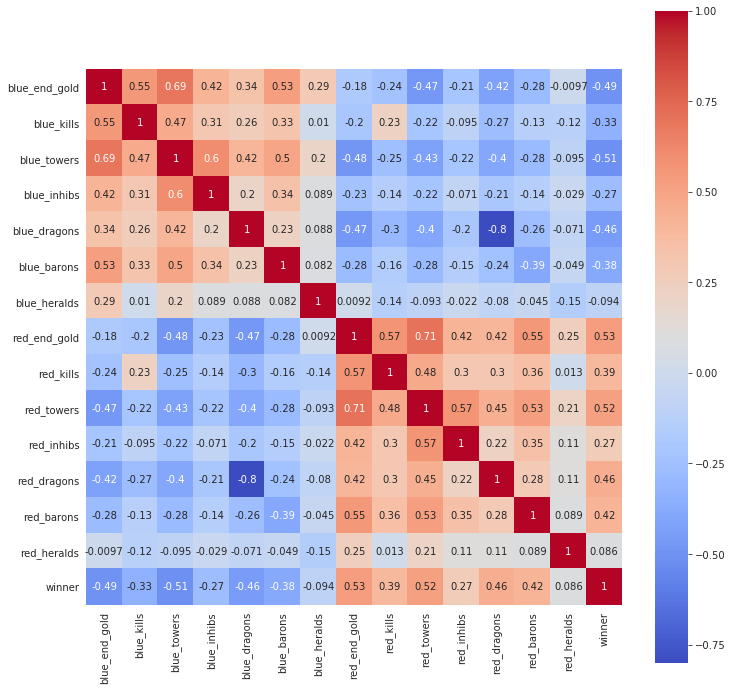

In [8]:
fig = plt.figure(figsize=(12,12))

sns.set_style('darkgrid')
sns.heatmap(data[['blue_end_gold','blue_kills', 'blue_towers', 'blue_inhibs', 'blue_dragons', 'blue_barons', 'blue_heralds', 'red_end_gold','red_kills','red_towers','red_inhibs', 'red_dragons', 'red_barons', 'red_heralds', 'winner']].corr(), annot=True, square=True, cmap='coolwarm')

From this heat map, we can average across blue and red teams. We find that the correlations between each objective and winning are:

- Towers Destroyed: ~0.52 (Moderate Correlation)
- Gold Earned: ~.50 (Moderate Correlation)
- Dragons Killed: 0.46 (Moderate Correlation)
- Barons Killed: 0.40 (Moderate Correlation)
- Kills: ~0.36 (Weak Correlation)
- Inhibitors Destroyed: 0.27 (Weak Correlation)
- Heralds Killed: 0.09 (Weak Correlation)


## Compute VIF: Assess Multicollinearity 
Blue and red dragons feature a notably high correlation. Let's compute the variance inflation factor between our predictor variables, and assess multicollinearity before training our models. 

In [9]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# find design matrix for regression model using 'winner' as response variable 
y, X = dmatrices('winner ~ blue_end_gold+blue_kills+blue_towers+blue_inhibs+blue_dragons+blue_barons+blue_heralds+red_end_gold+red_kills+red_towers+red_inhibs+red_dragons+red_barons+red_heralds', data=data[['blue_end_gold','blue_kills', 'blue_towers', 'blue_inhibs', 'blue_dragons', 'blue_barons', 'blue_heralds',
          'red_end_gold','red_kills','red_towers','red_inhibs', 'red_dragons', 'red_barons', 'red_heralds', 'winner']], return_type='dataframe')

# calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

# view VIF for each explanatory variable 
display(vif)

,VIF,variable
0,555.349716,Intercept
1,5.976842,blue_end_gold
2,2.665811,blue_kills
3,3.981469,blue_towers
4,1.615000,blue_inhibs
5,3.128605,blue_dragons
6,1.658492,blue_barons
7,1.210424,blue_heralds
8,6.382918,red_end_gold
9,2.790484,red_kills


We find that red and blue dragons slain do not have high VIF. However, We find that blue team gold and red team gold at the 30 minute mark to have high VIF:

- Blue Team Gold VIF = 5.98
- Red Team Gold VIF = 6.38

This makes sense given that team gold increases when taking any of the other objectives, both teams passively earn gold at an equal rate, and there are only a few other sources of team gold that are not accounted for here. To reduce the possibility of multicollinearity between our predictors, we'll drop `blue_end_gold` and `red_end_gold` before training our model. 

# Train Classification Models

## Split the Data

We want to split our data into a set that we train the model on and a set we test the model with. Using Scikit-learn, we can split our data so that we train on the majority (66.6%) and test the rest (33.3%) to see how we do.


In [10]:
X = data[['blue_kills', 'blue_towers', 'blue_inhibs', 'blue_dragons', 'blue_barons', 'blue_heralds',
          'red_kills','red_towers','red_inhibs', 'red_dragons', 'red_barons', 'red_heralds']]
X = data[['blue_kills', 'blue_towers', 'blue_inhibs', 'blue_dragons', 'blue_barons', 'blue_heralds',
          'red_kills','red_towers','red_inhibs', 'red_dragons', 'red_barons', 'red_heralds']]
y = data['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 1. Logistic Regression Model using scikit-learn

## Implement Logistic Regression Model

Fit logistic regression model to our training data.


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(X_train, y_train)

predictions = logmodel.predict(X_test)
weight = logmodel.coef_  
print(weight)

[[-0.15141789 -0.29079467 -0.0095092  -0.39035071 -0.46768037  0.03711597
   0.16988409  0.30468929  0.02484206  0.13186229  0.68343404 -0.11014533]]


## Evaluate the Trained Model

Now that we have a model, we can see how well we predicted the outcomes of the matches

Classification Report : 
               precision    recall  f1-score   support

           1       0.82      0.84      0.83       976
           2       0.82      0.79      0.81       880

    accuracy                           0.82      1856
   macro avg       0.82      0.82      0.82      1856
weighted avg       0.82      0.82      0.82      1856

Accuracy of Logistic Regression: 81.95%


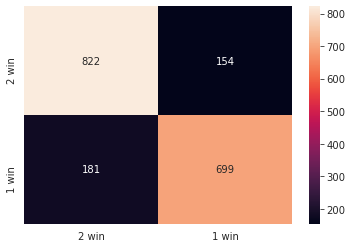

In [12]:
cr = classification_report(y_test, predictions)
print('Classification Report : \n', cr)

acc = round(logmodel.score(X_test, y_test) * 100, 2)
print("Accuracy of Logistic Regression: " + str(acc) + "%")

cm = confusion_matrix(y_test,predictions)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['2 win', '1 win'], yticklabels=['2 win', '1 win'],);

We can see that with this configuration, only in one of the 101 cases used for testing, the prediction made was wrong (99.01% of accuracy).

## Testing the Predictor

Let is simulate the test of the first row of the `data` dataset, in a **TSM x C9** match, where C9 lose the match, trying to predict who will win the match from the data provided.

In [13]:
# Predict the TSM x C9 match
x1 = [[16, 9, 2, 1, 0, 0,
       9, 4, 0, 3, 1, 0]]

pred = logmodel.predict_proba(x1).reshape(-1,1)

win = round(logmodel.predict(x1)[0], 2)
print("Winner is :", win)

fir_prob = round(pred[0][0] * 100, 2)
sec_prob = round(pred[1][0] * 100, 2) 
print("First team (blue) win probability is: " + str(fir_prob) + "%")
print("Second team (red) win probability is: " + str(sec_prob) + "%")

Winner is : 1
First team (blue) win probability is: 82.85%
Second team (red) win probability is: 17.15%


## 2. Logistic Regression Model using statsmodels

## Prepare the Data
Logistic regression in statsmodels requires an output between 0 and 1.

In [14]:
# winner = 1, when red wins. winner = 0, when blue wins
y_train = y_train-1
y_test = y_test-1

## Implement Logistic Regression Model
Fit logistic regression model to the training data and review results. View coefficients and compute 95% confidence interval for the odds-ratio for each predictor.  

In [15]:
# fit model to training data
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()

print(result.summary())
#print(result.params)
#print(result.conf_int())

# prepare coefficients and confidence intervals
ci = result.conf_int()
ci.rename(columns={0: 'lower', 1: 'upper'}, inplace=True)
coeffs = ci.assign(coefficients=result.params.values)

# compute odds ratios
coeffs["odds"] = math.e**coeffs["coefficients"]
coeffs["odds_lower"] = math.e**coeffs["lower"]
coeffs["odds_upper"] = math.e**coeffs["upper"]

display(coeffs)

Optimization terminated successfully.
         Current function value: 0.396501
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                 3766
Model:                          Logit   Df Residuals:                     3754
Method:                           MLE   Df Model:                           11
Date:                Sat, 22 Jan 2022   Pseudo R-squ.:                  0.4268
Time:                        06:27:52   Log-Likelihood:                -1493.2
converged:                       True   LL-Null:                       -2605.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
blue_kills      -0.1510      0.015    -10.249      0.000      -0.180      -0.122
blue_towers     -0.2881

,lower,upper,coefficients,odds,odds_lower,odds_upper
blue_kills,-0.179844,-0.122102,-0.150973,0.859871,0.835400,0.885058
blue_towers,-0.356973,-0.219233,-0.288103,0.749684,0.699791,0.803135
blue_inhibs,-0.348833,0.319955,-0.014439,0.985665,0.705511,1.377065
blue_dragons,-0.492515,-0.273705,-0.383110,0.681738,0.611087,0.760556
blue_barons,-0.703833,-0.241710,-0.472772,0.623272,0.494686,0.785284
blue_heralds,-0.142528,0.220030,0.038751,1.039512,0.867163,1.246114
red_kills,0.142217,0.198070,0.170144,1.185475,1.152827,1.219048
red_towers,0.237455,0.376265,0.306860,1.359151,1.268018,1.456833
red_inhibs,-0.356426,0.393191,0.018382,1.018552,0.700174,1.481701
red_dragons,0.033894,0.246066,0.139980,1.150251,1.034475,1.278983


Text(0.5, 1.0, 'Odds-Ratios for Red Team to Win')

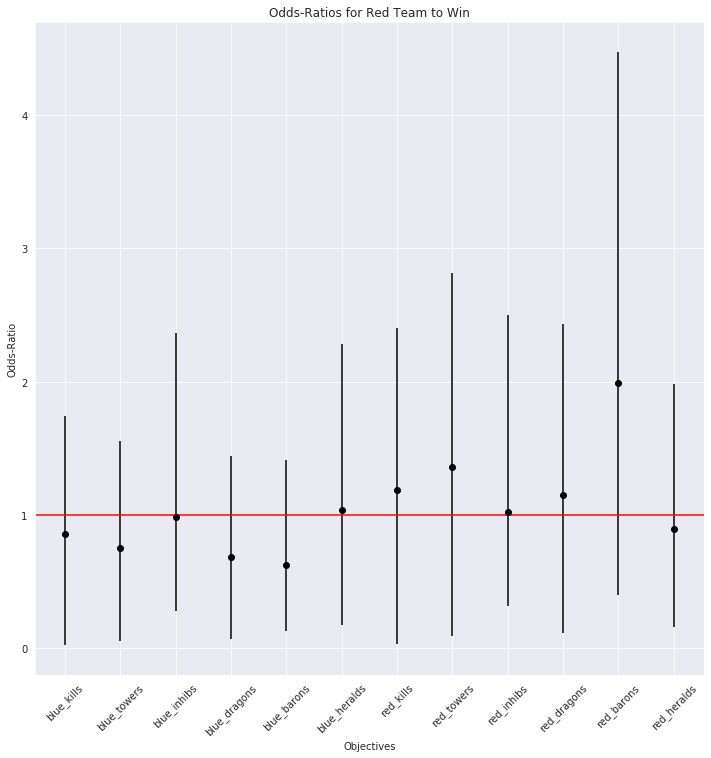

In [16]:
fig = plt.figure(figsize=(12,12))
                 
y = coeffs['odds']
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
#ticks = [tick-1 for tick in x]
errors = [coeffs['odds_lower'], coeffs['odds_upper']]
plt.errorbar(x, y, yerr=errors, fmt='ok')
plt.axhline(y=1, color='r', linestyle='-')
plt.xticks(x, list(coeffs.index), rotation=45)
plt.ylabel("Odds-Ratio")
plt.xlabel("Objectives")
plt.title("Odds-Ratios for Red Team to Win")

The logistic regression was used to analyze the relationship between objectives taken before 30 minutes and winning a game. The results are described in the above table. Odds-ratios with a 95% confidence interval for all predictors are computed. 

Let's envision ourselves as the *red team* to describe how objectives taken or given up before 30 minutes impact the odds of winning a game. The results of the logistic regression show the following significant relationships between a given predictor and winning the game, holding all other predictors constant:
- For each player kill, the odds of winning are expected to increase by 18% (95% CI [15%, 22%]).
- For each tower destroyed, the odds of winning are expected to increase by **35%** (95% CI [26%, 46%]).
- For each dragon killed, the odds of winning are expected to increase by 15% (95% CI [3%, 28%]).
- For each baron killed, the odds of winning are expected to increase by **99%** (95% CI [60%, 148%]).

Considering objectives given up to the enemy team:
- For each kill given up to the enemy team, the odds of winning are expected to decrease by 14% (95% CI [11%, 16%]).
- For each tower lost, the odds of winning are expected to decrease by 25% (95% CI [20%, 30%]).
- For each dragon taken by the enemy team, the odds of winning are expected to decrease by **32%** (95% CI [24%, 39%]).
- For each baron taken by the enemy team, the odds of winning are expected to decrease by **38%** (95% CI [21%, 50%]).

## Evaluate the Model

Evaluate model's predictions of match outcomes on unseen data. 

Accuracy of Logistic Regression Model is: 81.9%
Accuracy of Logistic Regression Model is: 81.9%


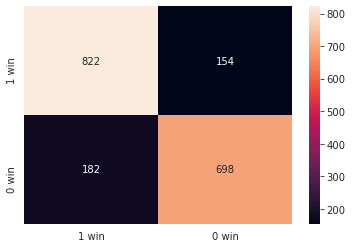

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

#print(X_test.shape, X_train.shape)
#print(X_test.columns, "\n", X_train.columns)

# retrieve predictions (i.e., yhat)
yhat = result.predict(X_test)
predictions = list(map(round, yhat))

# check actual y, and compute accuracy score
acc = accuracy_score(y_test, predictions)
acc = round(acc*100, 2)
print(f"Accuracy of Logistic Regression Model is: {acc}%")

# map confusion matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['1 win', '0 win'], yticklabels=['1 win', '0 win'],)
print(f"Accuracy of Logistic Regression Model is: {acc}%")

## Test Model on a Specific Case
Let's predict the winner for the 17th game in the `data` dataset. **Winterfox (WFX, Red team)** wins, defeating **Team Dignitas (DIG, Blue team)** in a 40 minute game, let's predict the winner based on the objectives taken in the first 30 minutes.  

In [18]:
# grab the 16 idx, 17th game 
X_case = X_train.loc[[16]]
y_case = y_train.loc[[16]]

# y_case = 1, red wins
display(X_case)
team_color = "Red team" if int(y_case[16]) == 1 else "Blue team" 
print(f"Winner is: {team_color}")

prob_1 = round(float(result.predict(X_case)),2)
winner = round(prob_1,1)
team_color = "Red team" if winner == 1 else "Blue team"
print(f"Predicted winner is: {team_color}")
print(f"Red team's probability of winning is: {prob_1*100}%")
print(f"Blue team's probability of winning is: {round((1-prob_1)*100,2)}%")

,blue_kills,blue_towers,blue_inhibs,blue_dragons,blue_barons,blue_heralds,red_kills,red_towers,red_inhibs,red_dragons,red_barons,red_heralds
16,1,4,0,0,0,0,8,6,0,4,1,0


Winner is: Red team
Predicted winner is: Red team
Red team's probability of winning is: 96.0%
Blue team's probability of winning is: 4.0%


The model computes a 96% probability for Red team to win the game, accurately predicting the Red team's win.

## Discussion

**Goal**. In this analysis, we aimed to determine the major factors which lead to winning or losing a League of Legends game, and attempt to predict the winner of a game based on objectives taken or given up before 30 minutes. 

**Models**. We were able to train a logistic regression model to predict the winner of competitive League of Legends games based on the objectives taken or given up before 30 minutes. We trained two models, one utilizing statsmodels and one utilizing scikit-learn. Despite only accessing the first 30 minutes of gameplay, both models were able to predict the future winner to ~80% accuracy. 

**Applications**. These models such as the ones developed here could be utilized by Riot while broadcasting competitive League of Legends games to present informative predictions of the winner of a match as the match progresses in real time. Additionally, amateur players are allowed to use 3rd-party applications while playing League of Legends matches. Building these models into a 3rd-party application could inform players of their odds of winning their current game, allowing them to make a more informed decision to either fight on or surrender early. These 3rd-party applications could also  describe the impact of map objectives on their odds of winning the game, in order to help a team decide their next moves.

**Findings**. The correlation heatmap suggests winning is moderately correlated betweeen towers taken, gold earned, and dragons and barons killed. The odds-ratios computed from the logistic regression model suggest players killed, towers destroyed, barons killed and dragons killed increase the odds of winning the game. Corroborating these findings, it is clear that towers destroyed, baron kills, dragon kills are highly impactful objectives to secure before 30 minutes. These results could inform efficient decision-making during a game. For example, a team could more effectively increase their odds of winning by choosing to slay a Dragon rather than a Herald, or by preparing to kill Baron rather than chasing a singular enemy player kill. 

## Conclusions

- Baron and dragon kills are highly impactful objectives to secure before 30 minutes to increase odds of winning the game. These map monsters could be prioritized over towers or champion kills (i.e. thirsting) to more efficiently improve a team's odds of winning.
- Securing an objective as the red team and denying that objective to the enemy blue team have different impacts on the winning. This could be due to slight differences the position of objectives on the map, relative to the red and blue bases. For example, Baron spawns on the blue side of the river (the map's midline), making it more difficult for the red team to secure. This could explain why red team taking Baron leads to a greater increase in winning odds than blue team taking Baron. This is corroborated by the opposite position of Dragon and opposite relative impact on odds when slaying Dragon. 
- The current models predict based on objective counts with no information about the time objectives were taken. However, certain objectives may be meaningful at different time-points throughout the game, possibly due to game-mechanics such as first-blood gold or (in future patches) turret plating awards. Computing the correlation between objectives and win outcome across time could offer useful insights towards how the impact of an objective changes from early, mid, to late game. Additionally, the time course of captured objectives could be better analyzed using a long short-term memory network, possibly leading to more accurate predictions of match outcomes. 